# Q-learning

# Dyna

# How to choose the right state space
## Leaving important things out: partial observability
## Too many states: computations become slow
## Just the right amount, but doesn't consider dynamics

46
58
38


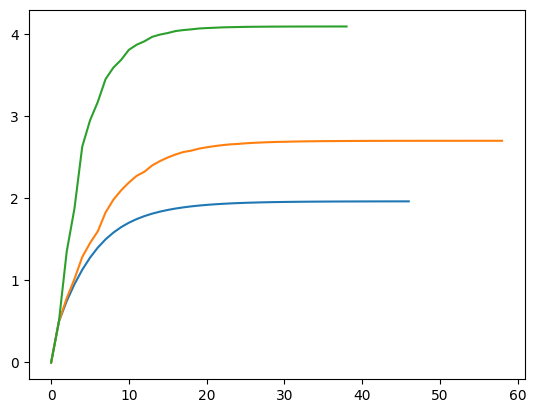

In [115]:
import numpy as np
import matplotlib.pyplot as plt
import random

def transition_probs(map, start_state):
    n_rows = len(map)
    n_cols = len(map[0])
    n_states = n_rows * n_cols
    n_actions = 4 # left, up, right, down
    action_neighbors = [(0, -1), (-1, 0), (0, 1), (1, 0)]
    T = np.zeros((n_states, n_states, n_actions))
    R = np.zeros((n_states))
    for row_idx, row in enumerate(map):
        for cell_idx, cell in enumerate(row):
            state_idx = row_idx * n_cols + cell_idx
            if cell > 1:
                R[state_idx] = cell
            for action in range(n_actions):
                if cell > 1:
                    T[state_idx, start_state, action] = 1.
                else:
                    target_row = row_idx + action_neighbors[action][0]
                    target_column = cell_idx + action_neighbors[action][1]
                    if target_row < 0 or target_row >= n_rows or target_column < 0 or target_column >= n_cols:
                        T[state_idx, state_idx, action] = 1.
                    else:
                        target_resistance = map[target_row][target_column] if map[target_row][target_column] <= 1 else 0
                        T[state_idx, state_idx, action] = target_resistance
                        target_state = target_row * n_cols + target_column
                        T[state_idx, target_state, action] = 1. - target_resistance
    return T, R

T = np.array([
    [[1, 1, 6/9, 6/9], [0, 0, 3/9, 0], [0, 0, 0, 0], [0, 0, 0, 3/9], [0, 0, 0, 0], [0, 0, 0, 0]],
    [[3/9, 0, 0, 0], [6/9, 1, 6/9, 1], [0, 0, 3/9, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]],
    [[0, 0, 0, 0], [3/9, 0, 0, 0], [6/9, 1, 1, 6/9], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 3/9]],

    [[0, 3/9, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [1, 6/9, 8/9, 1], [0, 0, 1/9, 0], [0, 0, 0, 0]],
    [[0, 0, 0, 0], [0, 1/4, 0, 0], [0, 0, 0, 0], [1/4, 0, 0, 0], [3/4, 3/4, 3/4, 1], [0, 0, 1/4, 0]],
    [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [1, 1, 1, 1], [0, 0, 0, 0], [0, 0, 0, 0]]
])

"""for s in range(T.shape[0]):
    for a in range(T.shape[2]):
        print(np.sum(T[s, :, a]))"""

R = np.array([0, 0, 0, 0, 0, 3])

large_map = [
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 1, 3, 3, 3],
    [0, 0, 0, 0, 0, 0, 3, 3, 3],
    [0, 0, 0, 1, 1, 1, 3, 3, 3]
]

small_map = [
    [0, 0, 0],
    [0, .75, 3]
]

small_init_state = 3
large_init_state = 36
T_map, R_map = transition_probs(large_map, start_state=large_init_state)
T_smap, R_smap = transition_probs(small_map, start_state=small_init_state)


def value_iteration(T, R, gamma, delta_threshold):
    n_states = R.shape[0]
    n_actions = T.shape[2]
    V = np.zeros((n_states))
    Q = np.zeros((n_states, n_actions))
    value_sums = [0]
    delta = np.inf
    iter = 0
    while delta > delta_threshold and iter < 1000:
        delta = 0
        for s in range(n_states):
            deltas_per_action = np.zeros((n_actions))
            for a in range(n_actions):
                Q[s, a] = 0
                for s_prime in range(n_states):
                    Q[s, a] += T[s, s_prime, a] * (R[s] + gamma * V[s_prime])
                deltas_per_action[a] = Q[s, a] - V[s]
            delta = np.maximum(delta, deltas_per_action.max())
            V[s] = Q[s, :].max()
        iter += 1
        value_sums.append(V.sum() / n_states)
        #print(Q)
    print(iter)
    #print(V)
    #print(Q)
    return value_sums

gamma = 0.85
delta_threshold = 0.0001

vs_po = value_iteration(T, R, gamma, delta_threshold)
vs_lm = value_iteration(T_map, R_map, gamma, delta_threshold)
vs_sm = value_iteration(T_smap, R_smap, gamma, delta_threshold)

plt.plot(vs_po)
plt.plot(vs_lm)
plt.plot(vs_sm)

/var/folders/jw/d5_trdxs6d10y2g48wcnb0880000gn/T/ipykernel_739/1283444698.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Q[act_state, action] = (1 - alpha) * Q[act_state, action] + alpha * TD


'vs_q_sm, _ = Q_learning(T_smap, R_smap, gamma, q_steps, alpha, epsilon, 3)\nplt.plot(vs_q_sm)'

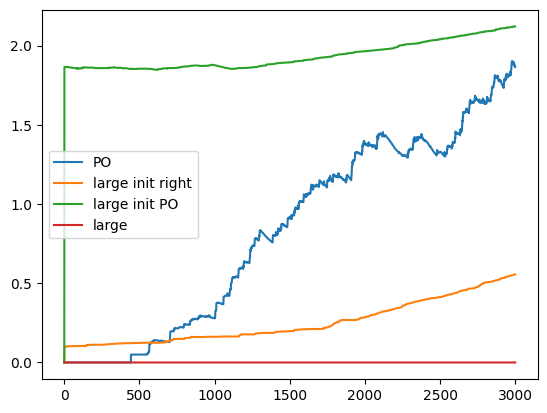

In [123]:
def Q_learning(T, R, gamma, max_iter, alpha, epsilon, init_state, Q_init=None):
    n_states = R.shape[0]
    n_actions = T.shape[2]
    states = list(range(n_states))
    actions = list(range(n_actions))
    Q = np.zeros((n_states, n_actions))
    if not Q_init is None:
        Q = np.copy(Q_init)
    value_sums = [0]
    act_state = init_state
    for i in range(max_iter):
        if random.uniform(0, 1) < epsilon:
            action = random.choice(actions)
        else:
            best_actions = np.argwhere(Q[act_state, :] == np.amax(Q[act_state, :])).flatten().tolist()
            action = random.choice(best_actions)

        #print(T[act_state, :, action].flatten())
        next_state = np.random.choice(states, size=1, p=T[act_state, :, action].flatten())
        reward = R[next_state]
        TD = reward + gamma * Q[next_state, :].max()
        Q[act_state, action] = (1 - alpha) * Q[act_state, action] + alpha * TD

        act_state = next_state
        value_sums.append(Q.sum() / n_states)
    return value_sums, Q

q_steps = 3000
alpha = 0.1
epsilon = 0.1

Q_init_right = np.zeros((T_map.shape[0], T_map.shape[2]))
Q_init_right[:, 2] = 0.1

vs_q_po, Q_po = Q_learning(T, R, gamma, q_steps, alpha, epsilon, small_init_state)
plt.plot(vs_q_po, label='PO')

#print(Q_po)

def coarse_grain_Q(small_map, large_map, Q_po):
    srow, scol = len(small_map), len(small_map[0])
    lrow, lcol = len(large_map), len(large_map[0])
    scale_coeff = int(lrow / srow)
    Q_init_coarse = np.zeros((lrow * lcol, Q_po.shape[1]))
    for sr in range(srow):
        for sc in range(scol):
            for lr in range(sr * scale_coeff, (sr + 1) * scale_coeff):
                for lc in range(sc * scale_coeff, (sc + 1) * scale_coeff):
                    s_state = sr * scol + sc
                    l_state = lr * lcol + lc
                    Q_init_coarse[l_state, :] = Q_po[s_state, :]
    return Q_init_coarse
#print(Q_init_coarse)


vs_q_lm_ir, _ = Q_learning(T_map, R_map, gamma, q_steps, alpha, epsilon, large_init_state, Q_init=Q_init_right)
plt.plot(vs_q_lm_ir, label="large init right")
vs_q_lm_ipo, _ = Q_learning(T_map, R_map, gamma, q_steps, alpha, epsilon, large_init_state, Q_init=coarse_grain_Q(small_map, large_map, Q_po))
plt.plot(vs_q_lm_ipo, label="large init PO")
vs_q_lm, _ = Q_learning(T_map, R_map, gamma, q_steps, alpha, epsilon, large_init_state, Q_init=None)
plt.plot(vs_q_lm, label="large")
plt.legend()
"""vs_q_sm, _ = Q_learning(T_smap, R_smap, gamma, q_steps, alpha, epsilon, 3)
plt.plot(vs_q_sm)"""

/var/folders/jw/d5_trdxs6d10y2g48wcnb0880000gn/T/ipykernel_739/1283444698.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Q[act_state, action] = (1 - alpha) * Q[act_state, action] + alpha * TD


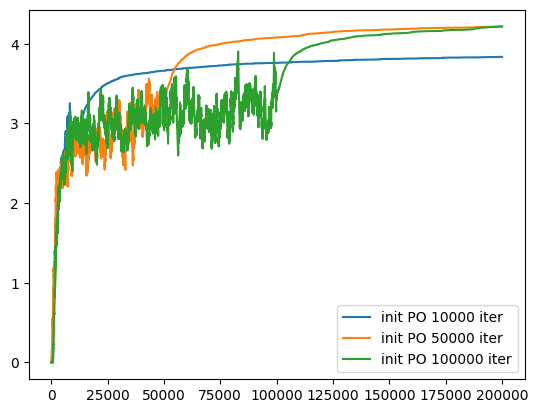

In [126]:
coarse_iterations = [10000, 50000, 100000]
full_iterations = 200000
for c_it in coarse_iterations:
    vs_q_po, Q_po = Q_learning(T, R, gamma, c_it, alpha, epsilon, small_init_state)
    vs_q_lm, _ = Q_learning(T_map, R_map, gamma, full_iterations - c_it, alpha, epsilon, large_init_state, Q_init=coarse_grain_Q(small_map, large_map, Q_po))
    plt.plot(vs_q_po + vs_q_lm[1:], label="init PO %d iter" % c_it)
plt.legend()